## <b> Setup <b/>
#### Reference: 
###### https://www.tensorflow.org/text/tutorials/classify_text_with_bert
###### https://colab.research.google.com/drive/1yWaLpCWImXZE2fPV0ZYDdWWI8f52__9A#scrollTo=EhpauvOIJzzf
###### https://colab.research.google.com/drive/1l39vWjZ5jRUimSQDoUcuWGIoNjLjA2zu

In [1]:
from utils.initialization import *
from utils.tokenizer import *
from utils.dataset_pipeline import *
from utils.servitization import *
from utils.visualization import *
from models.transformer_bert import *

Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory /data/Text_Tokenizer/vocab exists.
Directory /data/Text_Tokenizer/trained exists.
Directory /data/Text_Sentimentor/dataset exists.
Directory /data/Text_Sentimentor/datatf exists.
Directory /data/Text_Sentimentor/model/savedmodels exists.
Directory /data/Text_Sentimentor/model/checkpoints exists.
Directory /data/Text_Sentimentor/model/logs exists.
Directory /data/Text_Sentimentor/tmp exists.


In [2]:
### Tokenization Method

### Language Pair

lang_pair = ('en', None)
inp_lang, tar_lang = lang_pair

### Global Variables

MAX_LENGTH = 256

In [25]:
### Definition of Bert Model

bert_names = {'inp':BERT_NAMES['bert'][0],
              'tar':''}
cache_dirs = {'inp':os.path.join(DIR_MODELTORCH, bert_names['inp']),
              'tar':''}

print(f"Using Pretrained Bert Model: {bert_names}")
print(f"Cache Directory of Model: {cache_dirs}")
print(f"\nMax Length of Text: {MAX_LENGTH}")

Using Pretrained Bert Model: {'inp': 'bert-base-uncased', 'tar': ''}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/bert-base-uncased', 'tar': ''}

Max Length of Text: 256


## <b> 1. Download Dataset <b/>
#### <i> IMDB Dataset <i/>

In [5]:
### Download the dataset and record the path

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir=DIR_DATA, cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# remove unused folders to make it easier to load the data

remove_dir = os.path.join(dataset_dir, 'train', 'unsup')
shutil.rmtree(remove_dir)

In [6]:
def read_sentiment_dataset(data_dir, label_dict, preprocessor=None):
    data_dir = pathlib.Path(data_dir)
    
    texts, labels = [], []
    for label_dir in label_dict.keys():
        for text_file in (data_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(label_dict[label_dir])

    if preprocessor:
        texts = preprocessor(texts, py_function=True)
    return texts, labels

### Dataset loading & preprocessing

label_dict = {'pos':1, 'neg':0}
train_texts, train_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'train'), label_dict, text_preprocessors[inp_lang])
test_texts, test_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'test'), label_dict, text_preprocessors[inp_lang])

### Data splitting

n_keep = 0.1
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, 
                                                                        test_size=n_keep, random_state=SEED)

num_samples = len(train_texts)

### Demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(train_texts[:5], train_labels):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

Number of Training Data : 22500
Number of Validation Data : 2500
Number of Testing Data : 25000

Review: i'm a fan of the series and have read all 7 books. i wanted to see this just to see how it was done. all i can say, is that the only people who should watch this are ones who have already read the series and are curious about it. its pretty bad, and will turn you off reading them. not to be mean, but lucy is so ugly it detracts from the movie. was she the directors daughter? seriously, i'm sure the beavers in the movie were jealous of her teeth. she had an overbite that would put any beaver to shame. the movie just loses so much in translation. cs books don't translate as easily as the tolkein lotr books, or even harry potter. one thing they did right! aslan! very well done. although the other human actors with painted faces ( beavers, wolf) look silly, aslan was really well done since it was not just a human actor walking around. ( i guess its like that old horse custume? 2 people 

## <b> 2. Setup Tokenizer & Dataset Pipeline <b/>

In [7]:
tokenizers = tf.Module()
tokenizers.inp = AutoTokenizer.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp'], do_lower_case=True)
tokenizer_params = {
    'inp':{'add_special_tokens':True, 'padding':True, 'truncation':True, 'max_length':MAX_LENGTH, 
           'return_attention_mask':True, 'return_token_type_ids':False},
}

### Bert Tokenization: can only accept str, List[str] or List[List[str]]

train_encodings = dict(tokenizers.inp(train_texts, **tokenizer_params['inp']))
valid_encodings = dict(tokenizers.inp(valid_texts, **tokenizer_params['inp']))
test_encodings = dict(tokenizers.inp(test_texts, **tokenizer_params['inp']))

del train_texts, valid_texts, test_texts

### Tensorflow Dataset: the amount of data is small so using from_tensor_slices is enough

train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_encodings, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_encodings, test_labels))

In [8]:
BUFFER_SIZE = 2**13
BATCH_SIZE = 64

train_batches = make_batches(train_dataset, BATCH_SIZE, BUFFER_SIZE)
valid_batches = make_batches(valid_dataset, BATCH_SIZE)
test_batches = make_batches(test_dataset, BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)

({'input_ids': <tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[  101,  2043,  1037, ...,  2175,  2000,   102],
       [  101,  2694, 20306, ...,  1998,  1996,   102],
       [  101,  2074,  2004, ...,  1996,  9841,   102],
       ...,
       [  101,  2043,  2009, ...,  3043,  1012,   102],
       [  101,  1045,  2973, ...,     0,     0,     0],
       [  101,  2292,  1005, ...,  2025,  2005,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)>)


## <b> 3. Configure Training <b/>

### <b> Hyperparameters <b/>

In [12]:
### Configure pretrained model

configs = {'inp':AutoConfig.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp']),
           'tar':None}
pprint(configs)

### Configure training process

EPOCHS = 100
EARLYSTOP = 5

init_lr = 3e-5

### Configure downstream model structure ( Mark the unused hyperparameters )

num_layers = 1
num_projection_layers = 1
#embed_pos = True
embed_dim = 256
dense_dim = 512
num_heads = 8
dropout = 0.2
activation, activation_name = tf.nn.gelu, 'gelu'

all_tune = False
use_lstm = False

### Other configuration

#teacher = 100

{'inp': BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}
,
 'tar': None}


### <b> Loss & Metrics & Optimizer <b/>

In [13]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_function = tf.keras.metrics.BinaryAccuracy()

metrics = [accuracy_function] 

In [14]:
steps_per_epoch = num_samples//BATCH_SIZE+1
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                                       num_train_steps=num_train_steps,
                                                       num_warmup_steps=num_warmup_steps,
                                                       optimizer_type='adamw')
print(f'warmup_steps: {num_warmup_steps}')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


warmup_steps: 3520


### <b> Model <b/>

EN_Transformer_bert-base-uncased


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


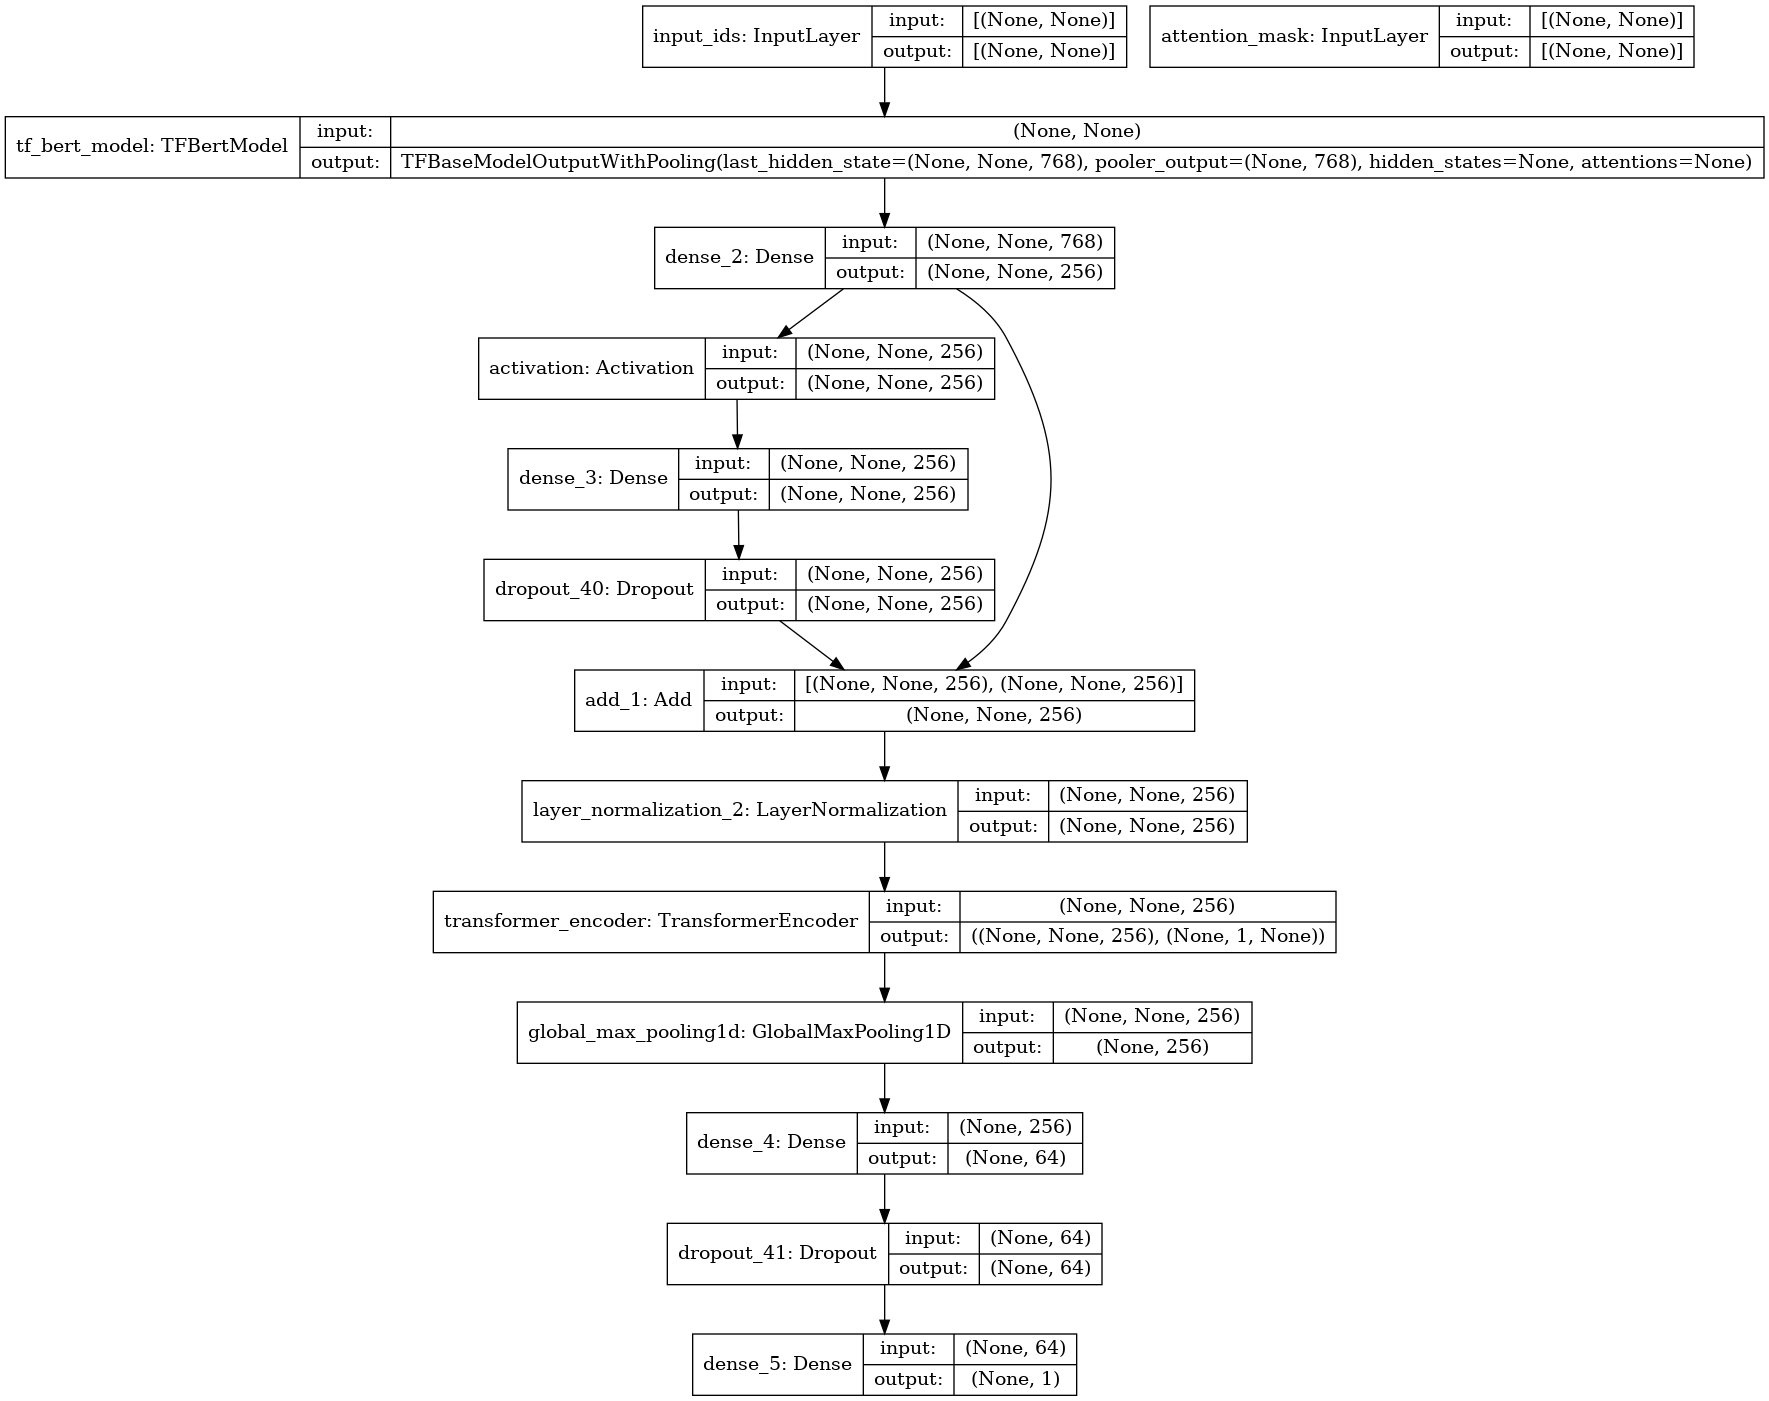

In [16]:
def build_model():
    
    ### Load pretrained bert model

    inp_pretrained_model = TFAutoModel.from_pretrained(bert_names['inp'], config=configs['inp'], cache_dir=cache_dirs['inp'])

    ### Build the downstream model

    input_ids = tf.keras.layers.Input(shape=(None,), name='input_ids', dtype='int32')
    input_masks = tf.keras.layers.Input(shape=(None,), name='attention_mask', dtype='int32') 
    encoder = TransformerEncoder(num_layers, embed_dim, num_heads, dense_dim, 
                                 activation=activation, dropout=dropout, embedding=False)
    
    # this is inline in config.output_hidden_states as we want only the top head.
    embedding_layer = inp_pretrained_model(input_ids, attention_mask=input_masks)[0]
    x = embedding_projector(embedding_layer, num_projection_layers, embed_dim, activation, dropout)
    x, _ = encoder(x, mask=input_masks)
    
    # Whether to use lstm as a feature collector
    if use_lstm:
        units = 32
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, dropout=dropout))(x)
    else:
        units = 64
        x = tf.keras.layers.GlobalMaxPool1D()(x)
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation=None)(x)
    
    model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=outputs)

    # Whether the fine-tune process including the pretrained model
    for layer in model.layers[:3]:
        layer.trainable = all_tune
    
    return model

# Plot the model
model_name = f"{inp_lang.upper()}_Transformer{'BiLSTM' if use_lstm else ''}_{bert_names['inp']}"
print(model_name)

model = build_model()
display(tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True))

## <b> 4. Training and checkpointing <b/>

### <b> Checkpoint <b/>

In [17]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id  = f"{num_layers}layers_{num_projection_layers}projlayers_{num_heads}heads_{embed_dim}embedding_{dense_dim}hidden"
run_id += f"_{dropout}dropout_{activation_name}_{num_warmup_steps}warmup_{optimizer._name}_{'all' if all_tune else 'part'}finetune"
run_id += f"_{BATCH_SIZE}batchsize_{BUFFER_SIZE}shuffle_{num_samples}samples"
print('run_id:', run_id, '\n')

# 設定存檔路徑
checkpoint_path = os.path.join(DIR_CHECKPOINT, model_name+'_'+run_id)
log_dir = os.path.join(DIR_LOG, model_name+'_'+run_id)

# 設定回調函數
es_metric = 'val_loss'

checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor=es_metric, save_weights_only=True, save_best_only=True, verbose=1, filepath=checkpoint_path)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor=es_metric, patience=EARLYSTOP, restore_best_weights=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks = [tensorboard, checkpoint, earlystopping]

# 回覆存檔點
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f'Restore the checkpoint at {latest_checkpoint}')
else:
    print("There is no existed checkpoint ... Start from the beginning.\n")

run_id: 1layers_1projlayers_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples 

There is no existed checkpoint ... Start from the beginning.



### <b> Training <b/>

In [ ]:
%%time

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

history = model.fit(train_batches, validation_data=valid_batches, 
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

### <b> Evaluation <b/>

In [21]:
%%time

loss, accuracy = model.evaluate(test_batches)

score = f"accuracy-{accuracy:.6f}-{dataset_dir[dataset_dir.rfind('/')+1:]}"
score

391/391 [==============================] - 268s 686ms/step - loss: 0.2279 - binary_accuracy: 0.9019
CPU times: user 27.1 s, sys: 2.98 s, total: 30.1 s
Wall time: 4min 28s


'accuracy-0.901920-aclImdb'

391/391 [==============================] - 153s 391ms/step - loss: 0.2610 - binary_accuracy: 0.8859
CPU times: user 19.1 s, sys: 1.72 s, total: 20.9 s
Wall time: 2min 32s


'accuracy-0.885920-aclImdb'

## <b> 5. Model Export & Pipeline Build <b/>

In [26]:
class HF2TFModelExporter(tf.Module):
    def __init__(self, model, bert_names, config_detail='', inp_lang='', tar_lang=''):
        self.model = model
        self.config_detail = tf.Variable(config_detail)
        
        self.inp_bert = tf.Variable(bert_names['inp'])        
        self.tar_bert = tf.Variable(bert_names['tar'])        
        self.inp_lang = tf.Variable(inp_lang)
        self.tar_lang = tf.Variable(tar_lang)    

    # Notice: the input should be encoded as token_ids and masks, 
    # and the signature need to be adjusted based on the number of masks
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.int32),
                                  tf.TensorSpec(shape=[None, None], dtype=tf.int32)])
    def __call__(self, input_ids, attention_mask):
        encoder_inputs = [input_ids, attention_mask]
        
        results = self.model(encoder_inputs, training=False)
        results = tf.nn.sigmoid(results)
        return results

### Build the fine-tuned predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFModelExporter(model, bert_names, config_detail=config_detail, inp_lang=inp_lang)

### Export the fine-tuned predictor

export_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=export_dir)

### Reload and construct the pipeline

model_dir = export_dir
pretrain_dir = DIR_MODELTORCH
pipeline = HF2TFClassifierPredictor(model_dir, pretrain_dir, text_preprocessors, max_length=MAX_LENGTH)

## <b> 6. Run Inference <b/>

In [53]:
sentences = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is a bad test', 
    'and happy one is here to be classified',
    'I broke up with my...cat, help me :(:(:(',
    'movie data seems to be not enough',
    'it is definitely not bad'
]

results = pipeline(sentences)
results_for_printing = [f"Input: {sentences[n]:<50} => score: {results[n][0]:.6f}"
                        for n, text in enumerate(sentences)]

print(*results_for_printing, sep='\n')

Input: this is such an amazing movie!                     => score: 0.997036
Input: The movie was great!                               => score: 0.989754
Input: The movie was meh.                                 => score: 0.611450
Input: The movie was okish.                               => score: 0.962687
Input: The movie was terrible...                          => score: 0.033495
Input: this is a bad test                                 => score: 0.008916
Input: and happy one is here to be classified             => score: 0.979038
Input: I broke up with my...cat, help me :(:(:(           => score: 0.720104
Input: movie data seems to be not enough                  => score: 0.007625
Input: it is definitely not bad                           => score: 0.822707
